In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

In [3]:
def set_figsize(figsize=(3.5, 2.5)):
    # Set picture's size
    plt.rcParams['figure.figsize'] = figsize
    
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    # plt.show()

In [4]:
##训练集
train_data=pd.read_csv(open('/kaggle/input/house-prices-advanced-regression-techniques/train.csv'))
##测试集
test_data=pd.read_csv(open('/kaggle/input/house-prices-advanced-regression-techniques/test.csv'))

# Visualization

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
10


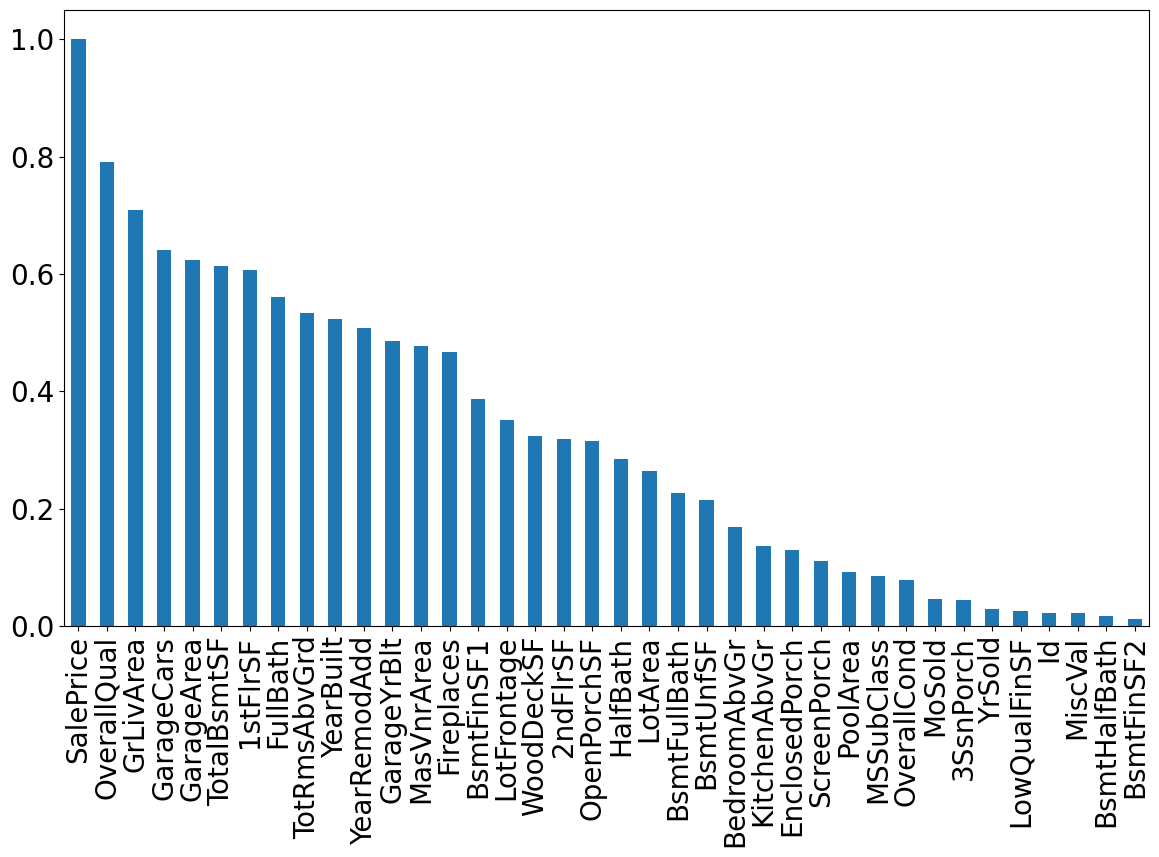

In [5]:
import matplotlib .pyplot as plt
fig = plt.figure(figsize=(14,8))
corr_with_saleprice = abs(train_data.corr(numeric_only=True)['SalePrice']).sort_values(ascending=False)
corr_with_saleprice.plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
variables = corr_with_saleprice[corr_with_saleprice > 0.5].index.tolist()
variables.remove('SalePrice')
print(variables)
print(len(variables))

There are **10** attributes that have colleration greater than 0.5.



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


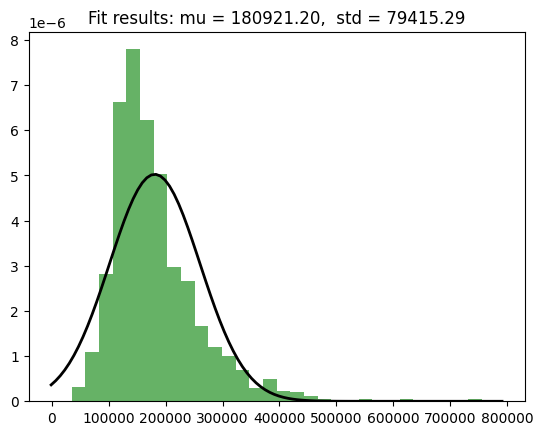

In [6]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import norm

# Calculate the mean and standard deviation of your data
mu, std = norm.fit(train_data['SalePrice'])

# Plot the histogram
plt.hist(train_data['SalePrice'], bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Set the plot title
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

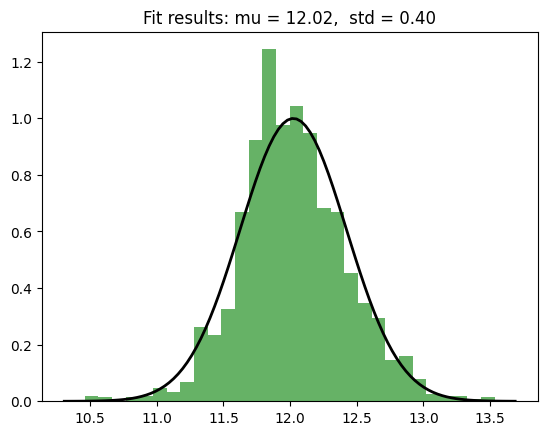

In [7]:
# Log(data)
mu, std = norm.fit(np.log(train_data['SalePrice']))

# Plot the histogram
plt.hist(np.log(train_data['SalePrice']), bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Set the plot title
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

After taking the logarithm, it is found that it basically conforms to the normal distribution, and **linear regression modeling** can be performed.

<Figure size 640x480 with 0 Axes>

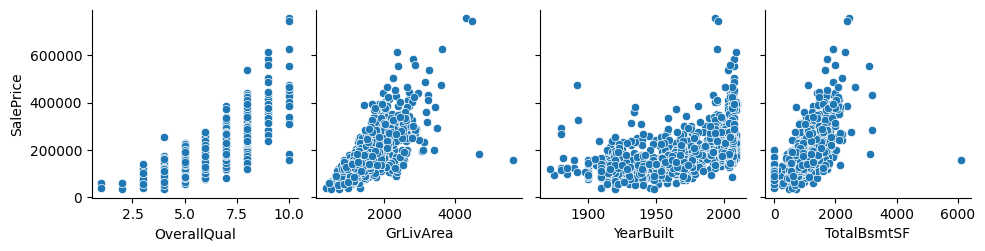

In [8]:
# Outlier handling
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

In [9]:
# Drop
train_data = train_data.drop(train_data[(train_data['OverallQual']<5) &
                                        (train_data['SalePrice']>200000)].index)
 
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) &
                                        (train_data['SalePrice']<300000)].index)
 
train_data = train_data.drop(train_data[(train_data['YearBuilt']<1900) &
                                        (train_data['SalePrice']>400000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) &
                                        (train_data['SalePrice']<200000)].index)

<Figure size 640x480 with 0 Axes>

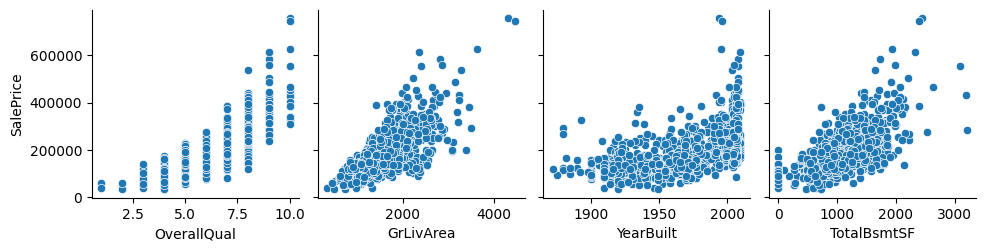

In [10]:
# Check
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

In [11]:
# Combine data
# Delete ID and SalePrice
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))

In [12]:
# Fill in missing values
nan_index = ((all_features.isnull().sum()/len(all_features))).sort_values(ascending=False)
print(nan_index)

PoolQC           0.996913
MiscFeature      0.963979
Alley            0.932075
Fence            0.804460
FireplaceQu      0.487136
                   ...   
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
SaleCondition    0.000000
Length: 79, dtype: float64


In [13]:
# Find all numeric features
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
# Normalization

all_features[numeric_features]=all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std()))
# Fill nan values with 0
all_features[numeric_features]=all_features[numeric_features].fillna(0)
# Discrete values are converted into indicator features
all_features=pd.get_dummies(all_features,dummy_na=True)

In [14]:
# Split the dataset into train set and test set
n_train=train_data.shape[0]
# Numpy -> Tensor
# train features
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float)
# test features
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float)
# train lables
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

In [15]:
loss = torch.nn.MSELoss()

In [16]:
def get_net(feature_num):
    net = nn.Sequential(
         FlattenLayer(),
            nn.Linear(feature_num,256),
            nn.ReLU(),
            nn.Linear(256,1),
    )
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [17]:
# log mean square error
def log_rmse(net, features, labels):
    with torch.no_grad():
        # Set the value less than 1 to 1, 
        # the value is more stable when taking the logarithm
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [18]:
def train(net,train_features,train_labels,test_features,test_labels,
          num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    # Add to DataLoader
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    # Adam
    optimizer=torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net=net.float() #Float
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [19]:
# K Fold
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        
        if j==1:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        # train data
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            # dim=0: merge by column
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid
def k_fold(k,X_train,y_train,num_epochs,
           learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net(X_train.shape[1])
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,
                                weight_decay,batch_size)
        # Cumulative error
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            semilogy(range(1,num_epochs+1),train_ls,
                         'epochs','rmse',
                         range(1,num_epochs+1),valid_ls,
                         ['train','valid'])
            # Output：training error, validation error
        print('fold%d,train rmse %f,valid rmse %f'%
              (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

fold0,train rmse 0.092620,valid rmse 0.108134
fold1,train rmse 0.089874,valid rmse 0.105190
fold2,train rmse 0.084350,valid rmse 0.109370
fold3,train rmse 0.080396,valid rmse 0.106540
fold4,train rmse 0.082955,valid rmse 0.105595
fold5,train rmse 0.083547,valid rmse 0.104131
fold6,train rmse 0.085679,valid rmse 0.107739
fold7,train rmse 0.082946,valid rmse 0.106276
8-fold validation:avg trian rmse 0.085296,avg valid rmse 0.106622


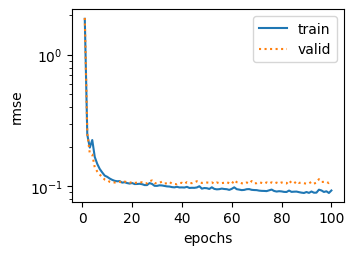

In [20]:
# Choose Model
k,num_epochs,lr,weight_decay,batch_size=8,100,0.1,300,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg trian rmse %f,avg valid rmse %f'%
      (k,train_l,valid_l))

In [21]:
# Predicatation
def train_and_pred(train_features,test_features,train_labeld,test_data,
                   num_epochs,lr,weight_decay,batch_size):
    net=get_net(train_features.shape[1])
    # _ test error
    train_ls,_=train(net,train_features,train_labels,None,None,
                     num_epochs,lr,weight_decay,batch_size)
    semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
    print('train rmse %f'%train_ls[-1])
    preds=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./submission.csv',index=False)   

train rmse 0.084813


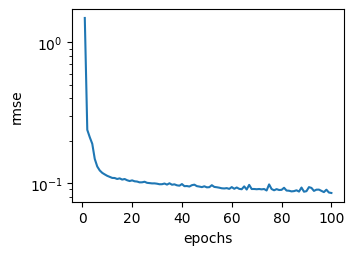

In [22]:
train_and_pred(train_features,test_features,train_labels,
               test_data,num_epochs,lr,weight_decay,batch_size)  